In [1]:
# %%
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import squidpy as sq
import spatialdata as sd
import seaborn as sns
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")

/home/cgobet/miniconda3/envs/spatial/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/cgobet/miniconda3/envs/spatial/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# Import custom plotting helpers
import sys
sys.path.insert(0, "/workspaces/cgobet/2026_06_01_spatial_exploratory/CoPhaser/paper/code/set_up")
import plot_helpers
import constants

### Load Data

In [3]:
path = '/data/cgobet/2026_06_01_spatial_exploratory/data/'

# Load spatial data
sdata_spatch = sd.read_zarr(os.path.join(path, "spatch/xenium_ovary_spatch.zarr"))
sdata_10x = sd.read_zarr(os.path.join(path, "10x/xenium_ovary_10x.zarr"))

# Load processed anndata
adata = sc.read_h5ad(os.path.join(path, 'xenium_ovary_both_processed.h5ad'))

### Extract Color Schemes from AnnData

In [4]:
cell_type_categories = adata.obs['cell_type'].cat.categories
cell_type_colors = adata.uns['cell_type_colors']
color_dict = dict(zip(cell_type_categories, cell_type_colors))

### Define Cell Cycle Color Schemes

In [ ]:
# Binary cell cycle status
cell_cycle_binary_colors = {
    "G0/G1": "#1f78b4",        
    "Proliferative": "#ff7f00" 
}

# Detailed cell cycle phases
cell_cycle_phase_colors = {
    "G0/G1": "#e0e0e0",   
    "G1/S": "#f0e442",    
    "S": "#56b4e9",       
    "G2/M": "#d55e00"     
}

cc_order = ["G0/G1", "G1/S", "S", "G2/M"]


### Split and Update Spatial Data Tables

In [ ]:
def update_sdata_table(adata, sdata, dataset_name):

    from spatialdata.models import TableModel
    
    # Extract dataset-specific cells
    adata_subset = adata[adata.obs['dataset'] == dataset_name].copy()
    
    # Prepare for SpatialData
    adata_subset.obs.index = adata_subset.obs['cell_id'].astype(str)
    adata_subset.obs['instance_id'] = adata_subset.obs.index
    adata_subset.obs['region'] = "cell_boundaries"
    adata_subset.obs['region'] = adata_subset.obs['region'].astype('category')
    
    # Remove redundant cell_id column
    if 'cell_id' in adata_subset.obs.columns:
        adata_subset.obs = adata_subset.obs.drop(columns=['cell_id'])
    
    # Parse as TableModel
    adata_subset = TableModel.parse(
        adata_subset,
        region="cell_boundaries",
        region_key="region",
        instance_key="instance_id"
    )
    
    # Update spatial data
    sdata['table'] = adata_subset
    
    print(f"Updated {dataset_name} table: {adata_subset.shape}")
    return sdata

sdata_spatch = update_sdata_table(adata, sdata_spatch, 'spatch')
sdata_10x = update_sdata_table(adata, sdata_10x, '10x')

Updated spatch table: (372113, 4929)
Updated 10x table: (1062506, 4929)


In [7]:
# Clean up memory
del adata

### Harmonize Cell Cycle Phase Categories

In [8]:
# Merge G0 and G1 into G0/G1 for both datasets
for sdata in [sdata_spatch, sdata_10x]:
    sdata['table'].obs['cell_cycle_phase'] = (
        sdata['table'].obs['cell_cycle_phase']
        .replace({'G0': 'G0/G1', 'G1': 'G0/G1'})
        .astype('category')
        .cat.reorder_categories(cc_order, ordered=True)
    )

### Utility Functions for Plotting

In [9]:
def ultra_fast_plot(sdata, shape_key, color_col, ax, palette_dict):
    """Fast spatial plotting using datashader."""
    gdf = sdata.shapes[shape_key].copy()
    gdf["x"] = gdf.geometry.centroid.x
    gdf["y"] = gdf.geometry.centroid.y
    gdf[color_col] = sdata['table'].obs[color_col]
    gdf[color_col] = gdf[color_col].astype('category')
    
    x_min, x_max = gdf.x.min(), gdf.x.max()
    y_min, y_max = gdf.y.min(), gdf.y.max()
    
    canvas = ds.Canvas(
        plot_width=600, 
        plot_height=600,
        x_range=(x_min, x_max),
        y_range=(y_min, y_max)
    )
    
    agg = canvas.points(gdf, 'x', 'y', ds.count_cat(color_col))
    img = tf.shade(agg, color_key=palette_dict, how='eq_hist')
    
    ax.imshow(
        img.to_pil(), 
        aspect='equal', 
        extent=[x_min, x_max, y_min, y_max],
        interpolation='nearest'
    )
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_axis_off()

def add_mosaic_legend(fig, palette_dict, ncol=1, side='left'):
    """Add legend to mosaic figure."""
    handles = [
        Line2D([], [], color=color, marker='o', linestyle='None',
               markersize=3, label=label)
        for label, color in palette_dict.items()
    ]
    
    pos = (0, 0.97) if side == 'left' else (0.8, 0.97)
    loc = 'upper left' if side == 'left' else 'upper right'
    
    fig.legend(
        handles=handles, title=None, loc=loc, bbox_to_anchor=pos,
        frameon=True, ncol=ncol, fontsize=6,
        handletextpad=0.1, labelspacing=0.2,
        columnspacing=0.5, borderaxespad=0.1
    )

def plot_spatial_zoom_to_mosaic(sdata, x_range, y_range, ax_type, ax_phase, 
                                 type_colors, phase_colors, type_order, phase_order,
                                 linewidth=0.15):
    """Plot zoomed spatial views of cell types and cell cycle phases."""
    gdf = sdata.shapes["cell_boundaries"].copy()
    gdf["cell_type"] = sdata['table'].obs["cell_type"]
    gdf["cell_cycle_phase"] = sdata['table'].obs["cell_cycle_phase"]
    
    gdf_zoom = gdf.cx[x_range[0]:x_range[1], y_range[0]:y_range[1]].copy()
    
    # Cell type colormap
    present_types = [c for c in type_order if c in gdf_zoom["cell_type"].unique()]
    type_palette = [type_colors[cat] for cat in present_types]
    type_cmap = mcolors.ListedColormap(type_palette)
    
    # Cell cycle colormap
    present_phases = [p for p in phase_order if p in gdf_zoom["cell_cycle_phase"].unique()]
    phase_palette = [phase_colors[phase] for phase in present_phases]
    phase_cmap = mcolors.ListedColormap(phase_palette)
    
    # Plot
    gdf_zoom.plot(
        ax=ax_type, column="cell_type", categorical=True,
        cmap=type_cmap, edgecolor='black', linewidth=linewidth
    )
    
    gdf_zoom.plot(
        ax=ax_phase, column="cell_cycle_phase", categorical=True,
        cmap=phase_cmap, edgecolor='black', linewidth=linewidth
    )
    
    # Formatting
    ax_phase.set_title("Cell cycle phase (10x Genomics)", fontsize=8, fontweight='normal')
    ax_type.set_title("Cell type (10x Genomics)", fontsize=8, fontweight='normal')
    
    for ax in [ax_type, ax_phase]:
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.set_axis_off()
        ax.set_aspect('equal')


### Create Figure with Mosaic Layout

height_ratios_scaling: [1, 1, 1]


{'A': [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
 'C': <Axes: label='C'>,
 'D': [<Axes: >, <Axes: >],
 'E': [<Axes: >, <Axes: >]}

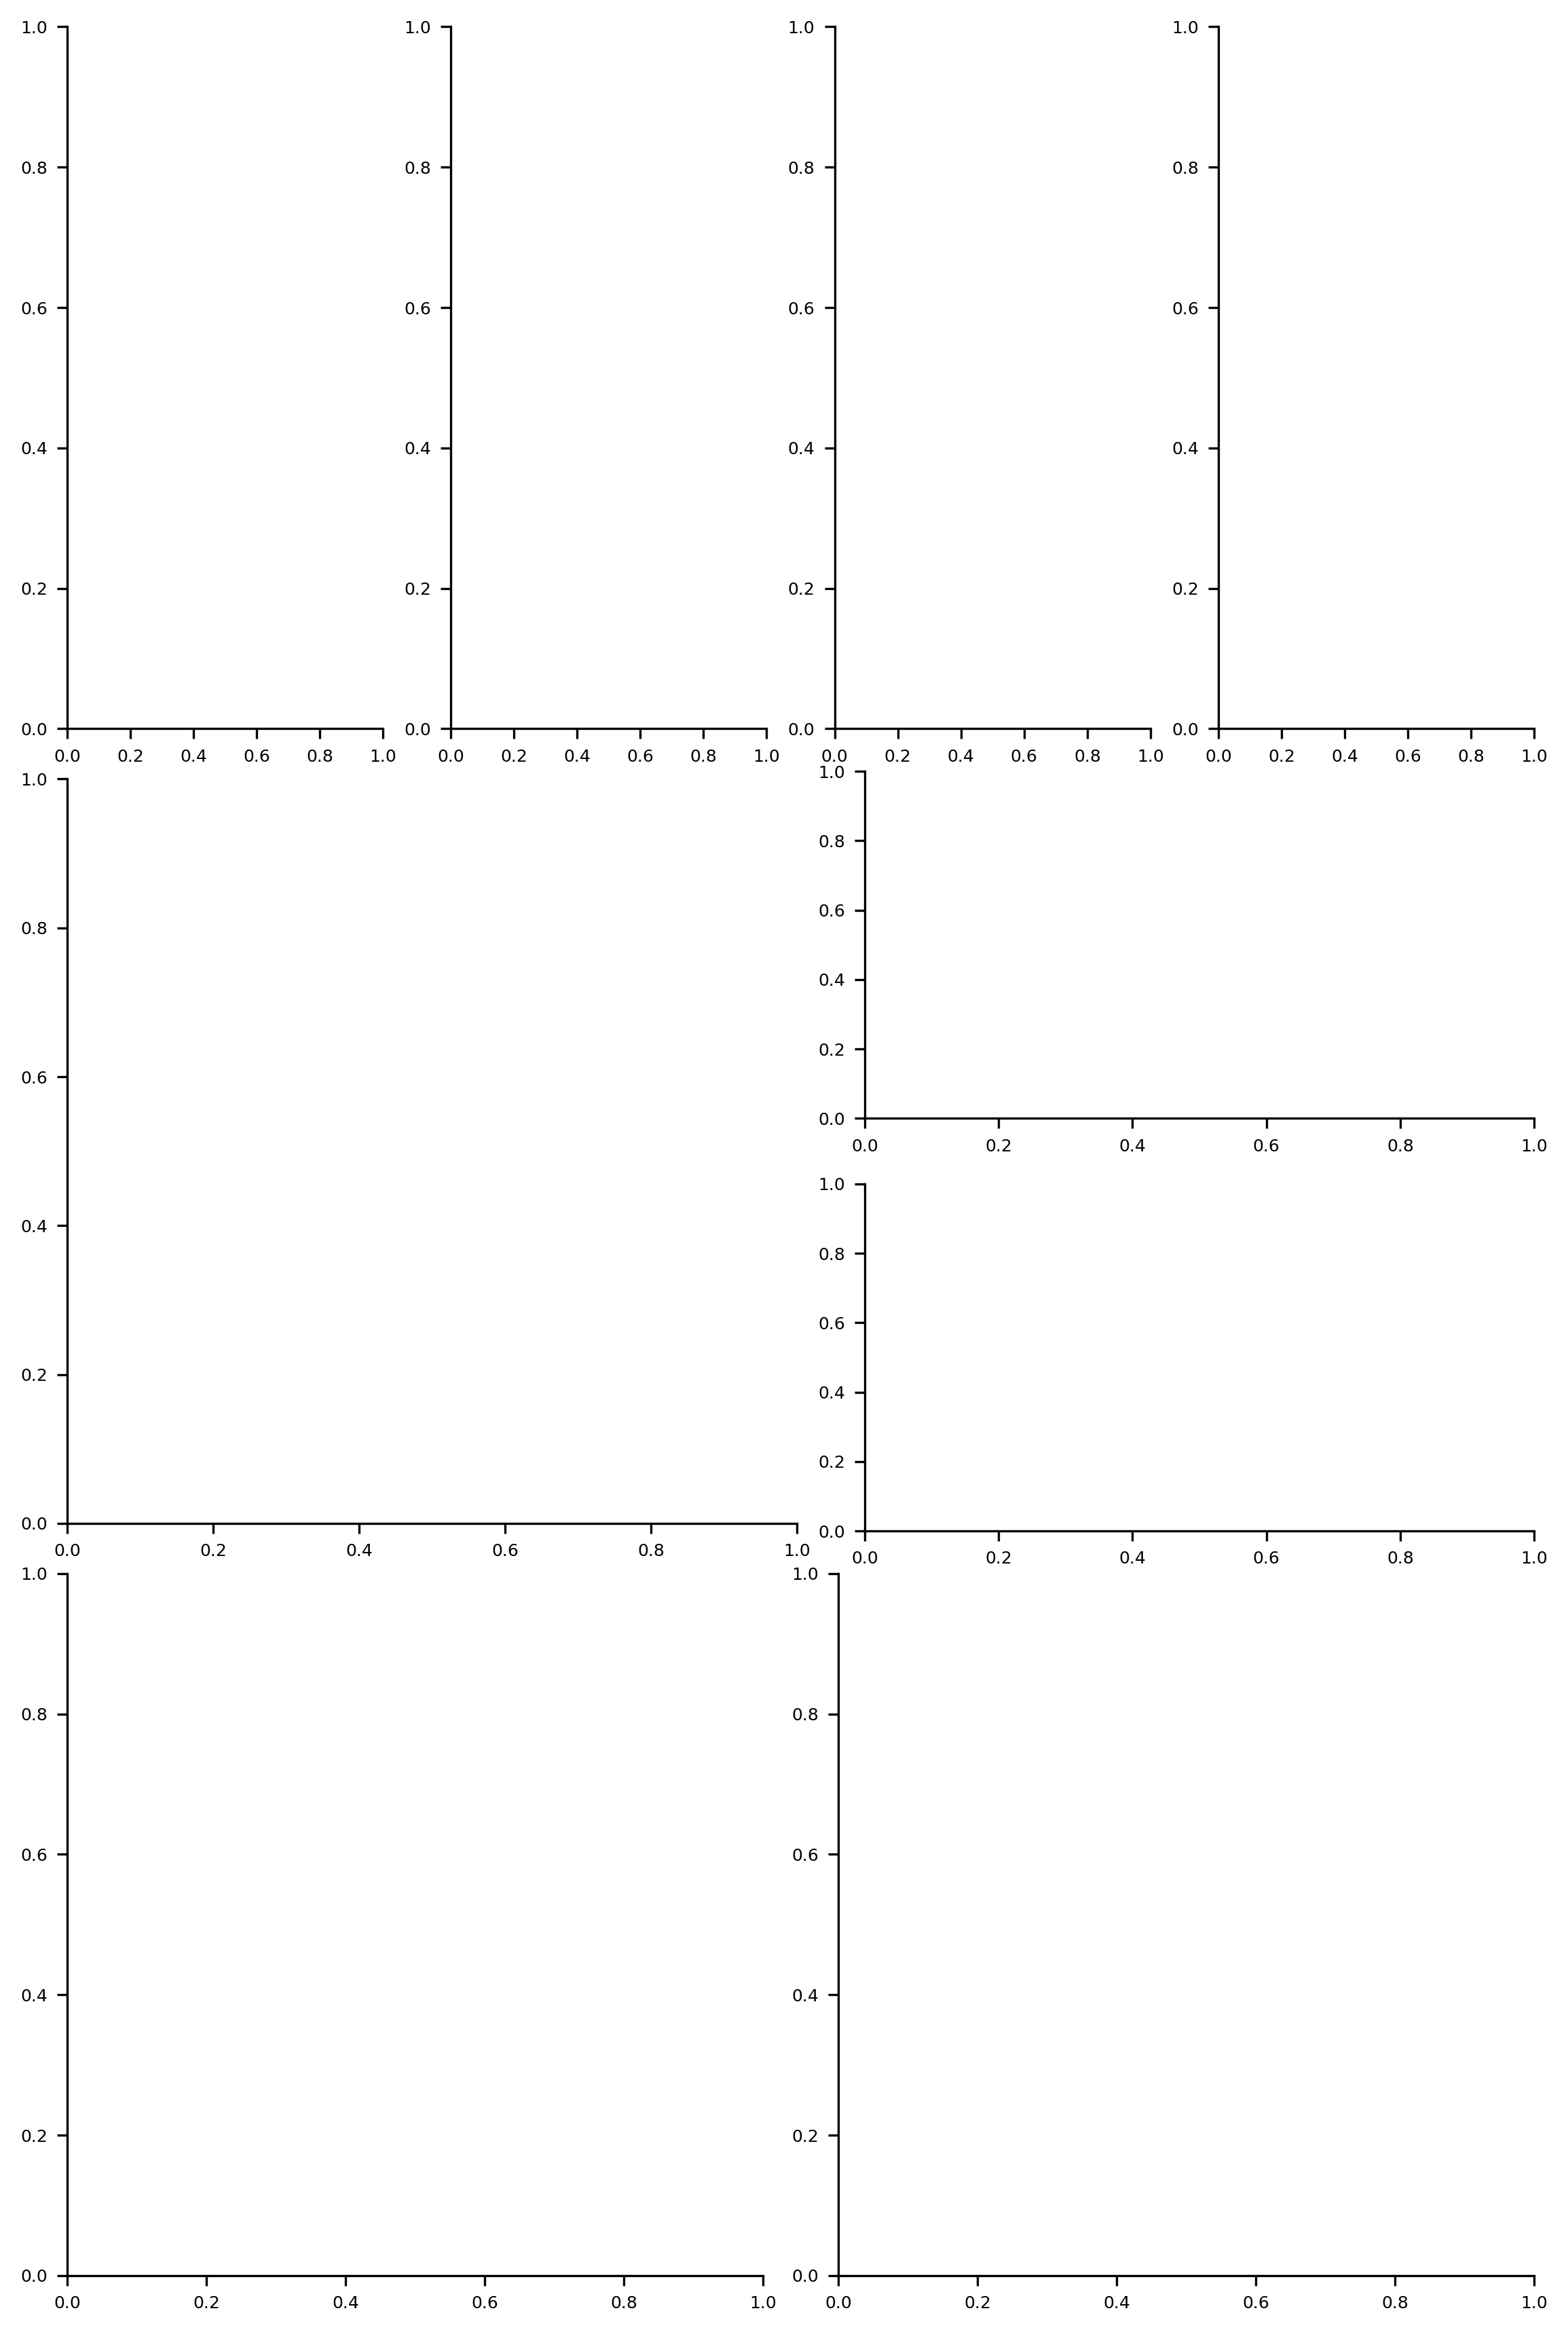

In [10]:
mosaic = [["A","A"], ["C", "D"], ["E", "E"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)
plot_helpers.replace_mosaic_cell_with_grid(fig, axs, "A", nrows=1, ncols=4)
plot_helpers.replace_mosaic_cell_with_grid(fig, axs, "D", nrows=2, ncols=1)
plot_helpers.replace_mosaic_cell_with_grid(fig, axs, "E", nrows=1, ncols=2)

### Panel A: Spatial Overview - Cell Cycle Status


In [11]:
ultra_fast_plot(
    sdata=sdata_spatch, 
    shape_key="cell_boundaries", 
    color_col="cell_type", 
    ax=axs["A"][0], 
    palette_dict=color_dict
)
axs["A"][0].set_title("Ren et al.",fontweight='normal')

Text(0.5, 1.0, 'Ren et al.')

In [12]:
ultra_fast_plot(
    sdata=sdata_10x, 
    shape_key="cell_boundaries", 
    color_col="cell_type", 
    ax=axs["A"][1], 
    palette_dict=color_dict
)
axs["A"][1].set_title("10x Genomics",fontweight='normal')

Text(0.5, 1.0, '10x Genomics')

In [13]:
add_mosaic_legend(
    fig=fig,
    palette_dict=color_dict, 
    ncol=1,
    side='left'
)

### Panel B: Spatial Overview - Cell Type


In [14]:
ultra_fast_plot(
    sdata=sdata_spatch, 
    shape_key="cell_boundaries", 
    color_col="cell_cycle_status_2", 
    ax=axs["A"][2], 
    palette_dict=cell_cycle_binary_colors
)
axs["A"][2].set_title("Ren et al.",fontweight='normal')

Text(0.5, 1.0, 'Ren et al.')

In [15]:
ultra_fast_plot(
    sdata=sdata_10x, 
    shape_key="cell_boundaries", 
    color_col="cell_cycle_status_2", 
    ax=axs["A"][3], 
    palette_dict=cell_cycle_binary_colors
)
axs["A"][3].set_title("10x Genomics",fontweight='normal')

Text(0.5, 1.0, '10x Genomics')

In [16]:
add_mosaic_legend(
    fig=fig,
    ncol=1,
    palette_dict=cell_cycle_binary_colors, 
    side='right')

### Panel C: Cell Cycle Phase Distribution by Cell Type

In [17]:

# Prepare combined dataset
df_10x = sdata_10x['table'].obs[['cell_cycle_phase', 'cell_type']].copy()
df_10x['study'] = '10x'

df_sp = sdata_spatch['table'].obs[['cell_cycle_phase', 'cell_type']].copy()
df_sp['study'] = 'spatch' 

combined = pd.concat([df_10x, df_sp])

proportions = pd.crosstab(
    [combined['cell_type'], combined['study']], 
    combined['cell_cycle_phase'], 
    normalize='index'
)

# Handle missing data - ensure all cell types have both datasets
full_index = pd.MultiIndex.from_product(
    [cell_type_categories, ['spatch', '10x']], 
    names=['cell_type', 'study']
)
proportions = proportions.reindex(full_index, fill_value=0)

# Plot stacked bar chart
cur_ax = axs['C']
bar_width = 0.35
group_gap = 1.0 

for i, cell_type in enumerate(cell_type_categories):
    x_base = i * group_gap
    
    data_10x = proportions.loc[(cell_type, '10x')]
    data_sp = proportions.loc[(cell_type, 'spatch')]
    
    bottom_10x = 0
    bottom_sp = 0
    
    for phase in cc_order:
        color = cell_cycle_phase_colors[phase]
        
        # Spatch bar
        cur_ax.bar(x_base, data_sp[phase], bar_width, bottom=bottom_sp, 
                   color=color, edgecolor='white', linewidth=0.5)
        bottom_sp += data_sp[phase]

        # 10x bar
        cur_ax.bar(x_base + bar_width, data_10x[phase], bar_width, bottom=bottom_10x, 
                   color=color, edgecolor='white', linewidth=0.5)
        bottom_10x += data_10x[phase]
        
cur_ax.set_xticks(np.arange(len(cell_type_categories)) * group_gap + bar_width / 2)
cur_ax.set_xticklabels(cell_type_categories, rotation=45, ha='right', fontsize=8)

# Non-bold title and clean labels
cur_ax.set_title('Ren et al. (left),  10x Genomics (right)', 
                fontsize=8, fontweight='normal')
cur_ax.set_ylabel('Fraction of Cells', fontsize=8)
cur_ax.set_ylim(0, 1)

# Legend
legend_elements = [Line2D([0], [0], color=cell_cycle_phase_colors[p], lw=4, label=p) for p in cc_order]
cur_ax.legend(handles=legend_elements, title="", 
              bbox_to_anchor=(1, 1), loc='upper left', frameon=True, fontsize=6)

cur_ax.grid(axis='y', linestyle='--', alpha=0.3)

### Panel D: Neighborhood Enrichment Analysis

In [18]:
# Calculate spatial neighbors
sq.gr.spatial_neighbors(sdata_10x['table'], coord_type="generic", delaunay=True)
sq.gr.spatial_neighbors(sdata_spatch['table'], coord_type="generic", delaunay=True)

In [19]:
# Calculate neighborhood enrichment
sq.gr.nhood_enrichment(sdata_10x['table'], cluster_key="cell_cycle_phase")
sq.gr.nhood_enrichment(sdata_spatch['table'], cluster_key="cell_cycle_phase")

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

In [20]:
# Extract and reorder enrichment matrices
phases_in_data = sdata_spatch['table'].obs['cell_cycle_phase'].cat.categories

df_sp = pd.DataFrame(
    sdata_spatch['table'].uns["cell_cycle_phase_nhood_enrichment"]['zscore'], 
    index=phases_in_data, columns=phases_in_data
)
df_10x = pd.DataFrame(
    sdata_10x['table'].uns["cell_cycle_phase_nhood_enrichment"]['zscore'], 
    index=phases_in_data, columns=phases_in_data
)

# Reorder to match cc_order
matrix_sp = df_sp.loc[cc_order, cc_order]
matrix_10x = df_10x.loc[cc_order, cc_order]

# Plot heatmaps
datasets = [(matrix_sp, "Ren et al."), (matrix_10x, "10x Genomics")]

for i, (mat, name) in enumerate(datasets):
    ax_target = axs['D'][i]
    
    # Calculate independent v_limit for this specific dataset
    v_limit = np.nanmax(np.abs(mat.values))
    
    # Plot heatmap 
    sns.heatmap(
        mat, 
        ax=ax_target,
        cmap="coolwarm",
        center=0,
        vmin=-v_limit,
        vmax=v_limit,
        cbar=True,  # Each plot gets its own colorbar now
        square=True,
        xticklabels=True, 
        yticklabels=True,
        cbar_kws={'label': 'Z-score', 'shrink': 0.8}
    )

    for j, phase in enumerate(cc_order):
        color = cell_cycle_phase_colors[phase]
        
        # Top color bar (X-axis)
        ax_target.add_patch(plt.Rectangle(
            (j, 0), 1, 0.05, color=color, 
            transform=ax_target.get_xaxis_transform(), clip_on=False
        ))
        
        # Left color bar (Y-axis)
        ax_target.add_patch(plt.Rectangle(
            (-0.05, j), 0.05, 1, color=color, 
            transform=ax_target.get_yaxis_transform(), clip_on=False
        ))

    # Formatting
    ax_target.set_xlabel("")
    ax_target.set_ylabel("")
    ax_target.set_title(name, fontsize=8, fontweight='normal', pad=0.2)
    ax_target.tick_params(axis='both', which='major', labelsize=7)

### Panel E: Spatial Zoom - Detailed View On Phase Patches

In [21]:
plot_spatial_zoom_to_mosaic(
    sdata_10x, 
    x_range=(1500, 3500), 
    y_range=(10000, 12000), 
    ax_type=axs['E'][0], 
    ax_phase=axs['E'][1],
    type_colors=color_dict,
    phase_colors=cell_cycle_phase_colors,
    type_order=list(cell_type_categories),
    phase_order=cc_order,
    linewidth=0.05
)

### Finalize and Save Figure

Figure saved to: /data/cgobet/2026_06_01_spatial_exploratory/data/Figure_Spatial_Main.svg


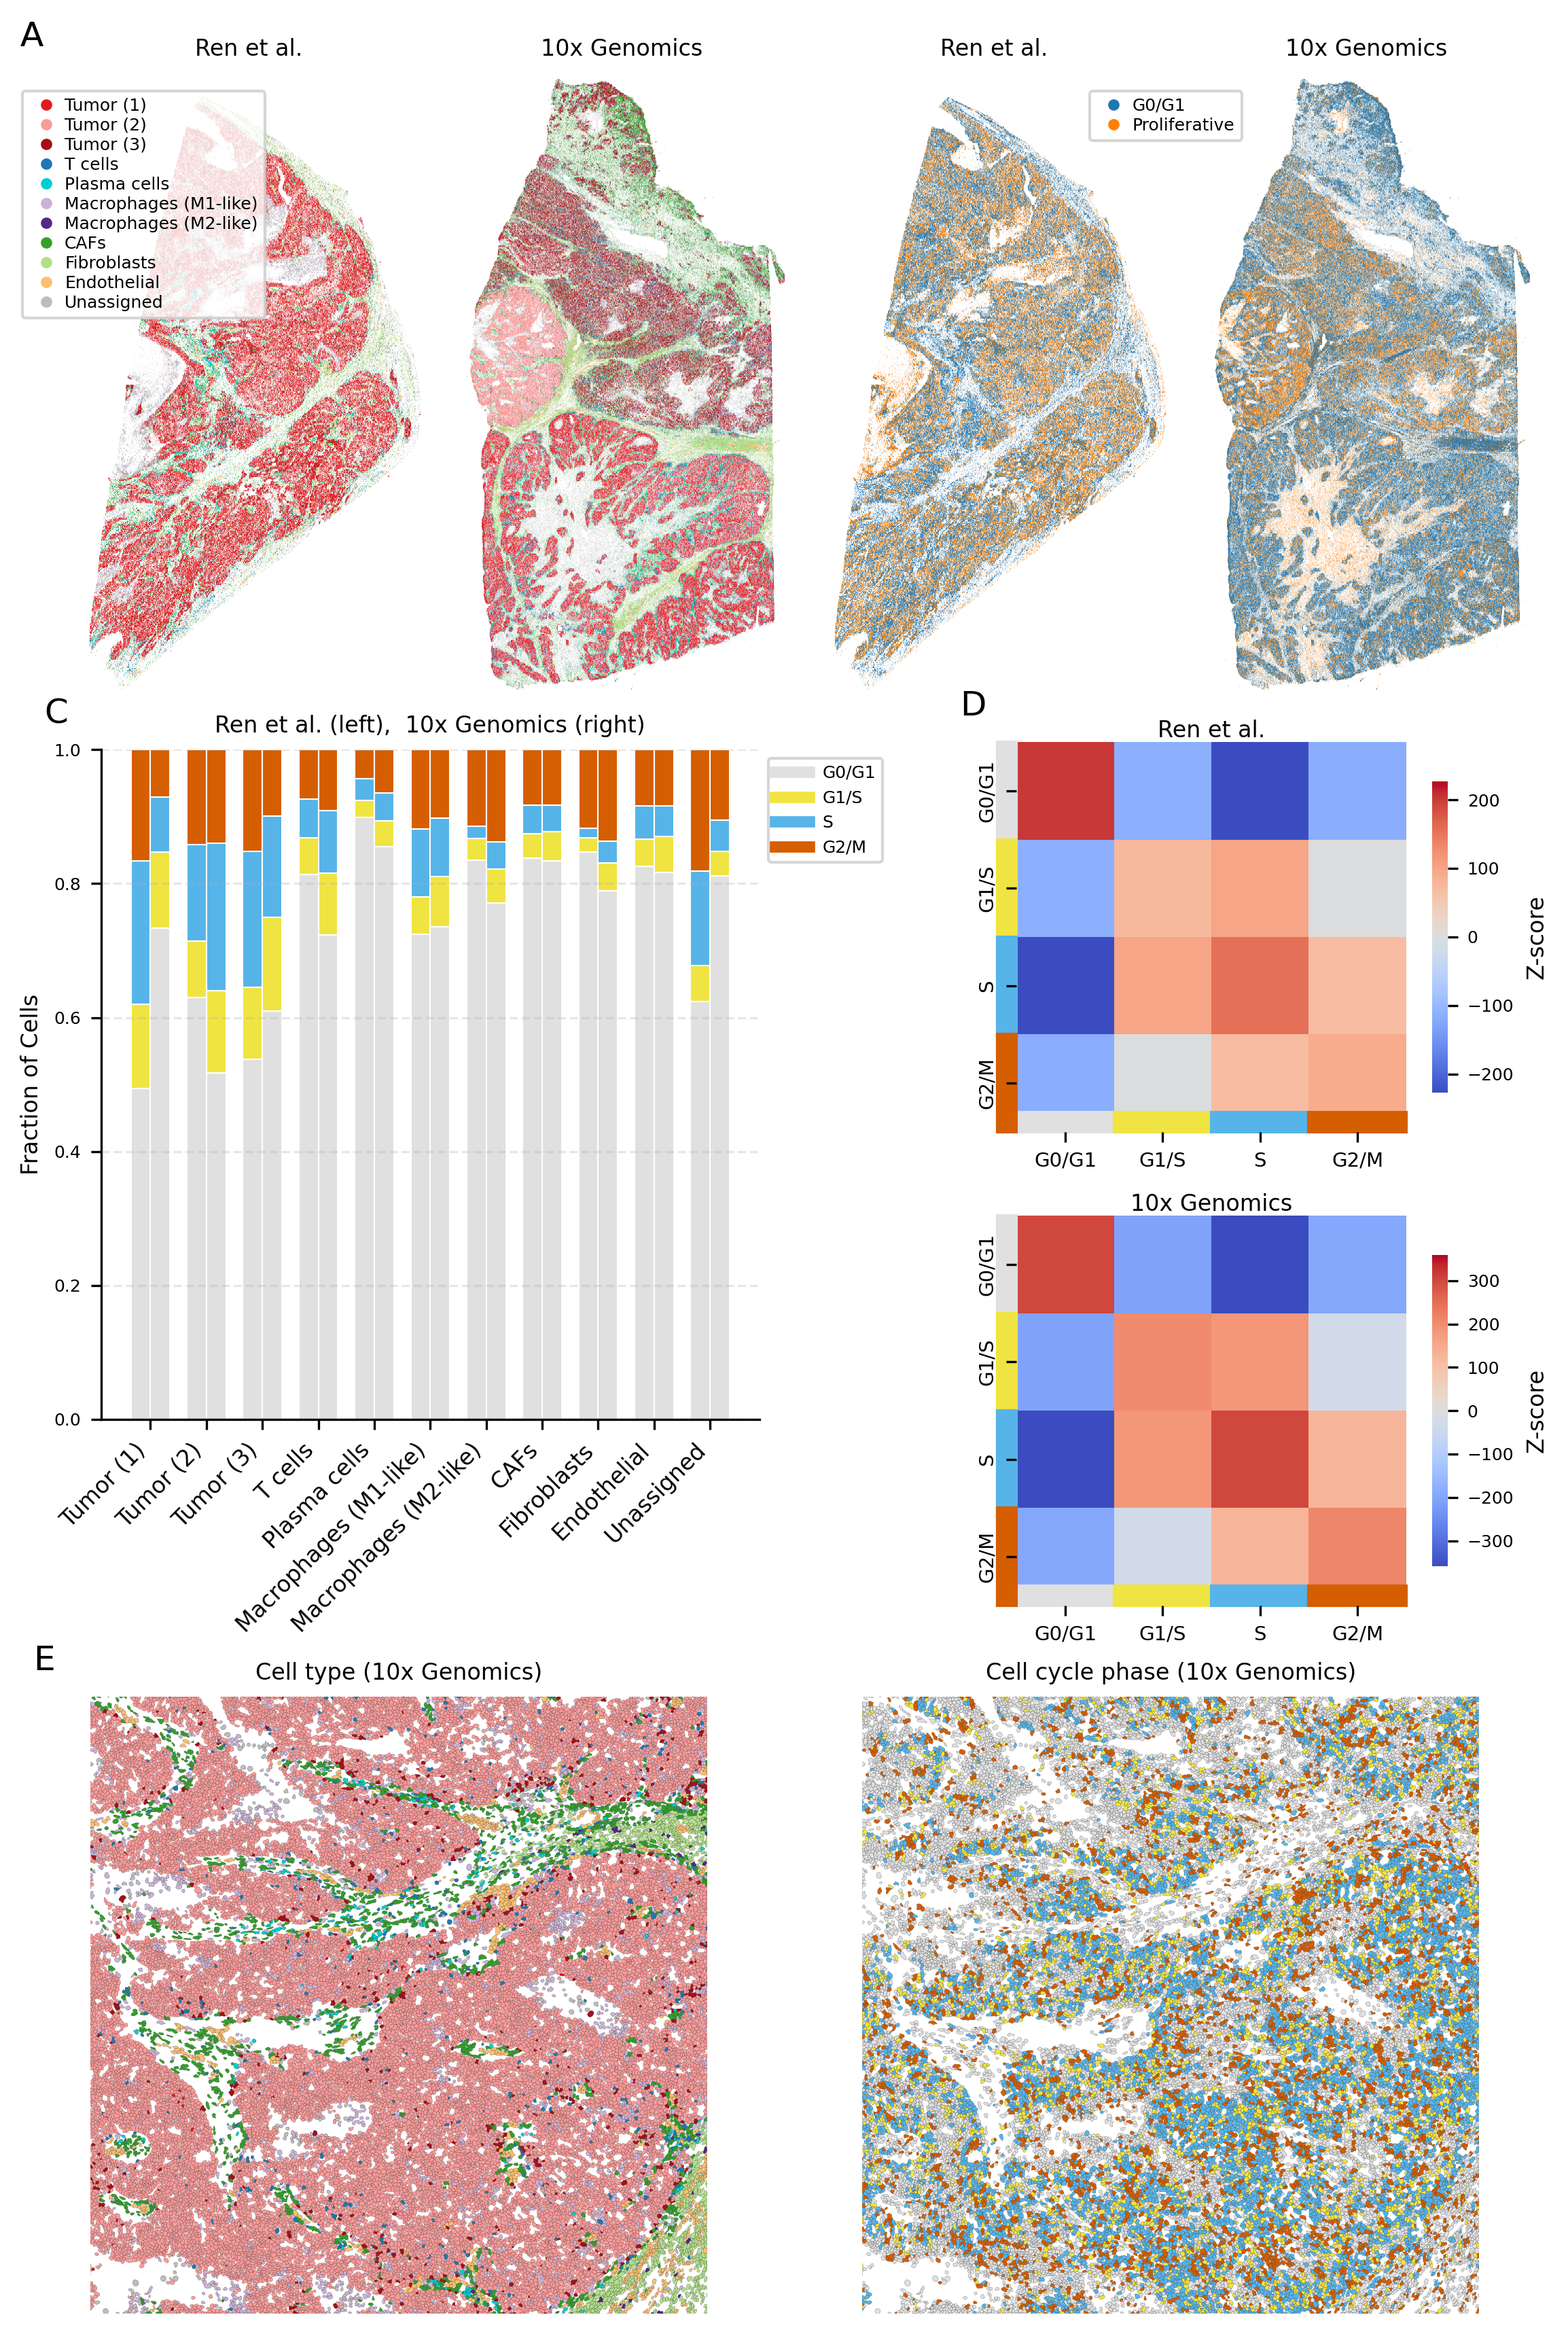

In [22]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic=mosaic)
plot_helpers.save_figure(fig, axs, "Figure_Spatial_Main", path, mosaic=mosaic)